In [7]:
#https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.129.020502

import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from numpy import linalg as LA
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info.operators import Operator
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
# from qiskit.tools.visualization import plot_histogram
from IPython.display import clear_output
import math


TFIM setting is the same as TFIM_GD_HEA.ipynb

In [8]:

num_q = 4
J = 1
Delta = 1.5
List_1 = []
op = ""
for i in range(num_q-1):
    op = ""
    for k in range(i):
        op += "I"
    op += "ZZ"
    for k in range(i+1,num_q-1):
        op += "I"
    List_1.append(op)

List_1.reverse()
H1 = SparsePauliOp(List_1, J*np.ones(num_q-1))  

List_2 = []
op = ""
for i in range(num_q):
    op = ""
    for k in range(i):
        op += "I"
    op += "X"
    for k in range(i+1,num_q):
        op += "I"
    List_2.append(op)
H2 = SparsePauliOp(List_2, Delta*np.ones(num_q))

H = SparsePauliOp.sum([H1,H2])

# Ordering e.g. IIIIIIZZ is the measurement of Z gates on the first two qubits and so forth.

Hmat = Operator(H)
Hmat = Hmat.data

e, v = LA.eig(Hmat)
min_index = np.argmin(e)
v_min = v[:,min_index]
ground_e = np.min(e)
print(H[0])
print(np.min(e))
print(H.size)
print(H.paulis[0])

scipy.io.savemat('Hmat.mat',{'Hmat':Hmat})

print(H)

SparsePauliOp(['IIZZ'],
              coeffs=[1.+0.j])
(-6.5038915571264155+0j)
7
IIZZ
SparsePauliOp(['IIZZ', 'IZZI', 'ZZII', 'XIII', 'IXII', 'IIXI', 'IIIX'],
              coeffs=[1. +0.j, 1. +0.j, 1. +0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j])


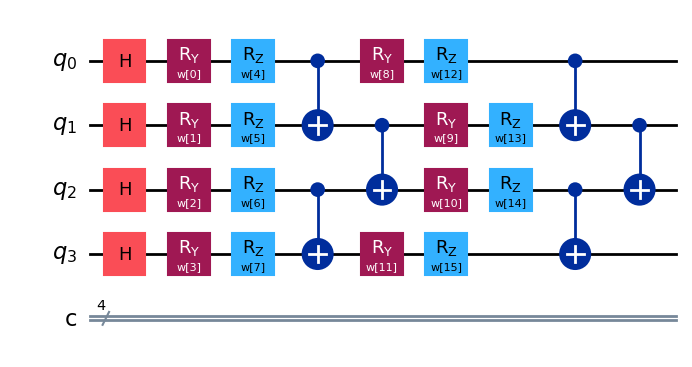

In [9]:
"""circuit construction"""
# num_q = 5
layer = 2 # qc.draw('mpl')时，注意第二层之后的 RY RZ 会被推到前面去
num_p = 2*layer*num_q 
weights = ParameterVector("w",num_p)

def circuit_ex(weights):
    circ = QuantumCircuit(num_q, num_q)
    for j in range(num_q):
        circ.h(j)
    for i in range(layer):
        for j in range(num_q):
            circ.ry(weights[2*i*num_q+j],j)
        for j in range(num_q):
            circ.rz(weights[2*i*num_q+num_q+j],j)
        for j in range(int(num_q/2)):
            circ.cx(2*j,2*j+1)
        for j in range(int(num_q/2)-1):
            circ.cx(2*j+1,2*j+2)
    return circ

qc=circuit_ex(weights)
qc.draw('mpl')

SparsePauliOp(['IIZZ', 'IZZI', 'ZZII', 'XIII', 'IXII', 'IIXI', 'IIIX'],
               coeffs=[1. +0.j, 1. +0.j, 1. +0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j])


In [10]:
simulator = AerSimulator()

# TFIM_GD_HEA2 代码比 TFIM_GD_HEA 代码简单些

def estimate_loss(WEIGHTS, SHOTS):

    # estimate_0 for Z gate
    estimate_0 = 0
    qc = circuit_ex(WEIGHTS)
    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc) ## output distribution of 0 and 1
    for i in range(SHOTS):
        for j in range(num_q-1):
            # [num_q-1-j] and [num_q-1-(j+1)]
            # 1,0
            # 2,1
            # 3,2
            # 将结果简单地线性相加即可
            if c[i][num_q-1-j] == c[i][num_q-1-(j+1)]:
                estimate_0 += 1
            else:
                estimate_0 += -1

    # 不要忘记还有一个系数 J            
    estimate_0 = J*estimate_0/SHOTS
    
    # estimate_1 for X gate
    estimate_1 = 0
    qc = circuit_ex(WEIGHTS)
    for i in range(num_q):
        qc.h(i)
    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc)
    for i in range(SHOTS):
        for j in range(num_q):
            if c[i][num_q-1-j] == '0':
                estimate_1 += 1
            else:
                estimate_1 += -1
    
    # 不要忘记还有一个系数 Delta
    estimate_1 = Delta*estimate_1/SHOTS

    # return estimate_0+estimate_1
    # 将结果简单地线性相加即可
    return estimate_0+estimate_1


def parameter_shift(WEIGHTS, INDEX, SHOTS):
    # compute partial derivative
    ## parameter shift rule with eigenvalues +-0.5
    identity = np.identity(num_p) # dentity matrix
    direction_index = np.pi/2 *identity[:,INDEX] 
    g_p = estimate_loss((WEIGHTS + direction_index.flatten()), SHOTS)  
    g_m = estimate_loss((WEIGHTS - direction_index.flatten()), SHOTS)
    g = 0.5 * (g_p - g_m) ## parameter shift rule with eigenvalues +-0.5
    return g



In [11]:

# TRUE expectation loss
# TRUE cost function for compute gradient
# 这里不需要shots，所以是直接计算的精确值。
# 就是用quadratic form 计算的电路的期望值。
def expectation_loss(WEIGHTS):
    qc = circuit_ex(WEIGHTS)
    qc.save_statevector()  # Save the statevector of the circuit for later retrieval
    qc = transpile(qc, simulator)  # Transpile the circuit to a form compatible with the simulator
    result = simulator.run(qc).result()  # Run the circuit on the simulator and get the result
    state_vector = result.get_statevector(qc)  # Retrieve the statevector of the final state
    psi = np.asarray(state_vector)  # Convert the statevector into a numpy array
    # ==========================================================================
    Hpsi = Hmat.dot(psi)  # Apply the Hamiltonian matrix (Hmat) to the statevector
    expectation = np.inner(np.conjugate(psi), Hpsi)  # Compute the inner product between psi and Hpsi
    return np.real(expectation)  # Return the real part of the expectation value

WEIGHTS = np.ones(num_p)
expectation_loss(WEIGHTS)

0.35604408998854176

We use the fidelity $\mathcal{F}$ between the VQE optimized state $\left|\psi\left(\boldsymbol{\theta}^*\right)\right\rangle$ and the true ground state $\left|\psi_{\text {ground }}\right\rangle$ obtained from exact diagonalization:

$$
\mathcal{F}=\left|\left\langle\psi\left(\boldsymbol{\theta}^*\right) \mid \psi_{\text {ground }}\right\rangle\right| .
$$


Note that for the models studied in this work, $\left|\psi_{\text {ground }}\right\rangle$ is always nondegenerate. If the fidelity is $>99.9 \%$, we assume that we have successfully found the ground state.

In [12]:
def fidelity(WEIGHTS):
    qc = circuit_ex(WEIGHTS)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)
    # ==========================================================================
    return np.absolute(np.vdot(psi,v_min))**2
    # v_min is ground state eigenvector

Loss and Fidelity: -6.314177532655579 0.9661419131724467


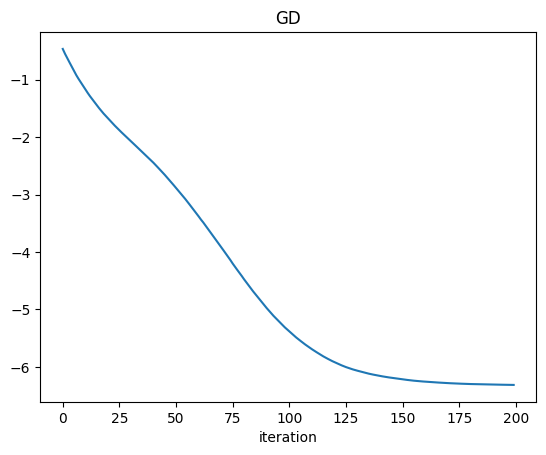

In [ ]:
"""optimization phase"""

"""initialization of weights"""
# w0 is weight 0 
mat = scipy.io.loadmat('w0')
w0 = mat['w0']

initial_weights = np.zeros(num_p) # np.ones(num_p)
initial_weights[:10] = w0.flatten()

T = 200
n_shot = 1000

# >>> np.empty([2, 2])
# array([[ -9.74499359e+001,   6.69583040e-309],
#        [  2.13182611e-314,   3.06959433e-309]])         #uninitialized
# >>> np.empty([2, 2], dtype=int)
# array([[-1073741821, -1067949133],
#        [  496041986,    19249760]])      

identity = np.identity(num_p)
num_results = 1

cost_mat = np.empty((0,T), int)
weight_mat = np.empty((0,T), int)
fidelity_mat = np.empty((0,T), int)

F = 0
iteration = 0
loss = 0 

for l in range(num_results):
    # 完全相同的设定下，重复多次

    cost = []
    cost_f = []
    Weights = []
    weights = initial_weights
    iteration = 0
    while iteration < T:
        iteration = iteration + 1

        # compute full estimated gradient
        gradient = []
        for j in range(num_p):
            index = j
            partial_gradient = parameter_shift(weights, index, n_shot)
            gradient.append(partial_gradient)
        gradient = np.array(gradient)

        # update weights
        a = 0.01 # learning rate
        weights = weights - a*gradient
        Weights.append(weights)
        
        F = fidelity(weights)
        loss = expectation_loss(weights)

        cost_f.append(F.flatten())
        cost.append(loss.flatten())
        
        # print info
        clear_output(wait=True)
        print('Loss and Fidelity:',loss, fidelity(weights))

        # plt.plot(cost)
        # plt.xlabel('iteration')
        # plt.title('GD')
        # plt.show()


    # save data
    Cost = np.asarray(cost) # save all cost/loss (ture cost function value)
    WEIGHTS = np.asarray(Weights) # save fianl Weights
    FIDELITY = np.asarray(cost_f) # save all fidelity

    #  因为多次重复实验，累计所有实验数据到cost_mat, weight_mat, fidelity_mat
    cost_mat = np.append(cost_mat, np.transpose(Cost), axis = 0)
    weight_mat = np.append(weight_mat, np.transpose(WEIGHTS), axis = 0)
    fidelity_mat = np.append(fidelity_mat, np.transpose(FIDELITY), axis = 0)
    
scipy.io.savemat('gd_loss.mat', {'gd_loss': cost_mat})
scipy.io.savemat('gd_weight.mat', {'gd_weight': weight_mat})
scipy.io.savemat('gd_fidelity.mat', {'gd_fidelity': fidelity_mat})


plt.plot(cost)
plt.title('GD')
plt.xlabel('iteration')
plt.show()
